**Angie Carolina Joya Duarte - 2322609**  

**Sheila Marcela Valencia Chito - 2243011**

# Entrega 2 - RNN

Se escogió para este trabajo el dataset "Twitter US Airline Sentiment"

## Importación y análisis del dataset

Importamos las librerías

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import re
import nltk

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import pad_sequences, to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import RegexpTokenizer

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Definimos las funciones auxiliares para graficar

In [25]:
def graficaDistribucion (dataset, atributo, etiquetas, ejeX, ejeY, titulo):
    graphOutput = sns.countplot(x=atributo, hue=atributo, data=dataset, palette="Set2", legend=False)
    total = len(dataset)

    for p in graphOutput.patches:
        count = p.get_height() #frecuencia absoluta
        percent = 100 * count / total #frecuencia relativa

        graphOutput.annotate(f'{percent:.1f}%', # formato de texto
            (p.get_x() + p.get_width() / 2., count/2),  #posición
            ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
            textcoords='offset points')

    ticks = graphOutput.get_xticks()
    graphOutput.set_xticks(ticks)
    graphOutput.set_xticklabels(etiquetas)
    graphOutput.set_xlabel(ejeX)
    graphOutput.set_ylabel(ejeY)
    graphOutput.set_title(titulo)

    plt.show()

In [26]:
def graficaEntrenamiento(resultado, set1, set2, titulo, ylabel):
    plt.plot(resultado.history[set1], label="Entrenamiento")
    plt.plot(resultado.history[set2], label="Validación")
    plt.title(titulo)
    plt.xlabel("Época")
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [27]:
def graficaMatriz(yTest_labels, yPred_labels):
  # Matriz de confusión
  cm = confusion_matrix(yTest_labels, yPred_labels)
  class_names = ['Negativo', 'Neutro', 'Positivo']

  # Graficar
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
  disp.plot(cmap=plt.cm.Blues)
  plt.title("Matriz de Confusión")

  plt.xlabel("Predicción")
  plt.ylabel("Etiqueta real")

  plt.show()

In [28]:
def graficaMatrizPorcentaje(y_true, y_pred):
    # Nombres de clases
    labels = ["Negativo", "Neutro", "Positivo"]

    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype("float") / cm.sum(axis=1, keepdims=True) * 100
    fig, ax = plt.subplots(figsize=(7, 6))

    # Graficar
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues, ax=ax, values_format=".1f")

    ax.set_title("Matriz de Confusión (%)")
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Etiqueta real")

    plt.show()

Importamos el dataset y lo almacenamos como un dataframe de pandas.

In [29]:
path = os.path.join(os.getcwd(), "Tweets.csv")
dataset = pd.read_csv(path, usecols=[1, 5, 10])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  14640 non-null  object
 1   airline            14640 non-null  object
 2   text               14640 non-null  object
dtypes: object(3)
memory usage: 343.3+ KB


## Preprocesamiento de los datos

Representamos las opiniones con etiquetas de enteros: 0 para negativa, 1 para neutral y 2 para positiva

In [30]:
dataset = dataset.drop(["airline"], axis=1)
dataset["sentiment"] = dataset["airline_sentiment"].replace({"negative" : 0, "neutral" : 1, "positive" : 2}).astype(int)
dataset = dataset.drop(["airline_sentiment"], axis=1)

C:\Users\USUARIO\AppData\Local\Temp;\ipykernel_13180\2424373769.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset["sentiment"] = dataset["airline_sentiment"].replace({"negative" : 0, "neutral" : 1, "positive" : 2}).astype(int)


Procesamos el texto para poder asignarle representaciones numéricas que se puedan utilizar en la Red Neuronal

In [31]:
nltk.download('stopwords')
palVacias = set(stopwords.words('english'))
palRaiz = SnowballStemmer('english')
tokenizador = RegexpTokenizer(r"\b\w+(?:'\w+)?\b")

#Además de stopwords, también eliminamos tags (@), links, y el # de los hashtags
usuarios = r"@\w*"
hashtags = r"#(\w+)"
links = r"http\S+"

#Los verbos conjugados en negación no reemplazan por "not" y no se eliminan
negaciones = r"\b(\w+)n't\b"

def preprocesamiento (tweet, stem=True):
    tweet = re.sub(usuarios, "", tweet)
    tweet = re.sub(hashtags, r"\1", tweet)
    tweet = re.sub(links, "", tweet)
    tweet = re.sub(negaciones, "not", tweet, flags=re.IGNORECASE)

    palabras = tokenizador.tokenize(tweet)
    texto = []

    #Convertimos el texto en un vector de palabras
    for palabra in palabras:
        palabra_lower = palabra.lower()
        # Conserva "no" y "not" aunque sean stopwords
        if palabra_lower == "not" or palabra_lower == "no" or palabra_lower not in palVacias:
            #Convertir verbos conjugados a su raíz
            if stem:
                texto.append(palRaiz.stem(palabra).lower())
            else:
                texto.append(palabra_lower)

    return " ".join(texto)

#Aplicar preprocesamiento a todo el dataset
dataset["textPrep"] = dataset.text.map(preprocesamiento)

dataset.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USUARIO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,sentiment,textPrep
0,@VirginAmerica What @dhepburn said.,1,said
1,@VirginAmerica plus you've added commercials t...,2,plus ad commerci experi tacki
2,@VirginAmerica I didn't today... Must mean I n...,1,not today must mean need take anoth trip
3,@VirginAmerica it's really aggressive to blast...,0,realli aggress blast obnoxi entertain guest fa...
4,@VirginAmerica and it's a really big bad thing...,0,realli big bad thing


La técnica de submuestreo Near Miss Centroids solo funciona cuando los datos a procesar son numéricos. Entonces implementamos otra técnica para balancear el dataset, Weighted Loss

In [32]:
class_weights = class_weight.compute_class_weight(
  class_weight='balanced',
  classes=np.unique(dataset["sentiment"]),
  y=dataset["sentiment"]
)

class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: np.float64(0.5317062540858575), 1: np.float64(1.5747015166182639), 2: np.float64(2.0651713922979265)}


El algoritmo TF-IDF no conserva el orden de las palabras, lo que es importante para las Redes Neuronales Recurrentes. Así que se usará el tokenizador de Keras para darle un valor numérico al texto preprocesado

In [33]:
#Tokenizar el texto preprocesado
tokenizerKeras = Tokenizer(num_words=2000, oov_token="<OOV>")
tokenizerKeras.fit_on_texts(dataset["textPrep"])

dataset["repTemporal"] = tokenizerKeras.texts_to_sequences(dataset["textPrep"])

dataset.head()

,text,sentiment,textPrep,repTemporal
0,@VirginAmerica What @dhepburn said.,1,said,[143]
1,@VirginAmerica plus you've added commercials t...,2,plus ad commerci experi tacki,"[441, 527, 1055, 118, 1]"
2,@VirginAmerica I didn't today... Must mean I n...,1,not today must mean need take anoth trip,"[3, 43, 646, 267, 20, 53, 83, 109]"
3,@VirginAmerica it's really aggressive to blast...,0,realli aggress blast obnoxi entertain guest fa...,"[72, 1, 1968, 1, 688, 1666, 919, 22, 388, 1]"
4,@VirginAmerica and it's a really big bad thing...,0,realli big bad thing,"[72, 371, 127, 200]"


Añadimos padding con 0 al final para qur todos los vectores tengan el mismo tamaño

In [34]:
X = pad_sequences(dataset["repTemporal"], maxlen=max(len(seq) for seq in dataset["repTemporal"]), padding='post')
dataset["token"] = list(X)
dataset = dataset.drop(columns=["repTemporal"])

dataset.head()

,text,sentiment,textPrep,token
0,@VirginAmerica What @dhepburn said.,1,said,"[143, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
1,@VirginAmerica plus you've added commercials t...,2,plus ad commerci experi tacki,"[441, 527, 1055, 118, 1, 0, 0, 0, 0, 0, 0, 0, ..."
2,@VirginAmerica I didn't today... Must mean I n...,1,not today must mean need take anoth trip,"[3, 43, 646, 267, 20, 53, 83, 109, 0, 0, 0, 0,..."
3,@VirginAmerica it's really aggressive to blast...,0,realli aggress blast obnoxi entertain guest fa...,"[72, 1, 1968, 1, 688, 1666, 919, 22, 388, 1, 0..."
4,@VirginAmerica and it's a really big bad thing...,0,realli big bad thing,"[72, 371, 127, 200, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


Convertir la salidas en vectores de binarios usando one hot encoding

In [35]:
dataset["one_hot"] = list(to_categorical(dataset["sentiment"], num_classes=3))

## RNN Vainilla

Definir los conjuntos de entrenamiento y prueba. 70% para entrenamiento, 15% para validación y 15% para pruebas

In [36]:
n = len(dataset["token"])

xTrain = np.array(dataset[:int(n*0.7)]["token"].to_list(), dtype="int32")
xVal = np.array(dataset[int(n*0.7):int(n*0.85)]["token"].to_list(), dtype="int32")
xTest = np.array(dataset[int(n*0.85):]["token"].to_list(), dtype="int32")

yTrain = np.array(dataset[:int(n*0.7)]["one_hot"].tolist(), dtype="float32")
yVal = np.array(dataset[int(n*0.7):int(n*0.85)]["one_hot"].tolist(), dtype="float32")
yTest = np.array(dataset[int(n*0.85):]["one_hot"].tolist(), dtype="float32")

print("Tamaño conjunto de entrenamiento: ",len(xTrain))
print("Tamaño conjunto de validación: ",len(xVal))
print("Tamaño conjunto de prueba: ",len(xTest))

Tamaño conjunto de entrenamiento:  10248
Tamaño conjunto de validación:  2196
Tamaño conjunto de prueba:  2196


Definir la arquitectura de la RNN

In [37]:
def RNN (entrada, salida, sizeEmbedding):
    modelo = keras.Sequential([
        layers.Embedding(
            input_dim=2000,     
            output_dim=sizeEmbedding,   
            input_length=entrada,
        ),        
        layers.Bidirectional(layers.SimpleRNN(
            64,
            activation="tanh",
            kernel_regularizer=regularizers.l2(0.0001),
            return_sequences=True,
            recurrent_dropout=0,
            dropout = 0.3
        )),        
        layers.SimpleRNN(
            32,
            activation="tanh",
            kernel_regularizer=regularizers.l2(0.001),
            return_sequences=True,
            recurrent_dropout=0,
            dropout = 0.2
        ),  
        layers.SimpleRNN(
            16,
            activation="tanh",
            kernel_regularizer=regularizers.l2(0.0001),
            return_sequences=False,
            recurrent_dropout=0
        ),        
        layers.Dense(salida, activation="softmax")
    ])
    opt = Adam(learning_rate=0.00001)
    modelo.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

    return modelo

Definir función de entrenamiento

In [38]:
def entrenamiento (xTrain, yTrain, xVal, yVal, xTest, yTest, modelo, epocas, lote, class_weights, es):
  callbacks = []
  
  if es: 
    callbacks.append(
      keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)
    )
        
  history = modelo.fit(
    xTrain, 
    yTrain, 
    validation_data=(xVal, yVal),
    epochs=epocas,
    batch_size=lote,
    class_weight=class_weights,
    verbose = 1,
    callbacks=callbacks,
  )
  
  loss, acc = modelo.evaluate(xTest, yTest, verbose=0)
  print(f"Accuracy de pruebas: {acc:.4f}")
  
  return history


Definir parámetros de entrenamiento

In [39]:
epocas = 200
lote = 32
entrada =  xTrain.shape[1]
salida = yTrain.shape[1]

print("Tamaño de la entrada:",entrada)
print("Tamaño de la salida:",salida)

Tamaño de la entrada: 25
Tamaño de la salida: 3


Entrenar el modelo

In [40]:
modelo = RNN(entrada, salida, 164)
resultado = entrenamiento(xTrain, yTrain, xVal, yVal, xTest, yTest, modelo, epocas, lote, class_weights, True)

resultados = {
  "Época": ["Primera", "Última"],
  "Loss": [resultado.history["loss"][0], resultado.history["loss"][-1]],
  "Val_Loss": [resultado.history["val_loss"][0], resultado.history["val_loss"][-1]],
  "Accuracy": [resultado.history["accuracy"][0], resultado.history["accuracy"][-1]],
  "Val_Accuracy": [resultado.history["val_accuracy"][0], resultado.history["val_accuracy"][-1]],
}

tabla = pd.DataFrame(resultados)
print(tabla)

Epoch 1/200


C:\Users\USUARIO\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


321/321 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.3088 - loss: 1.2930 - val_accuracy: 0.4035 - val_loss: 1.1535
Epoch 2/200
321/321 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.3618 - loss: 1.2352 - val_accuracy: 0.4467 - val_loss: 1.1236
Epoch 3/200
321/321 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.3950 - loss: 1.2086 - val_accuracy: 0.4982 - val_loss: 1.1019
Epoch 4/200
321/321 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.4400 - loss: 1.1807 - val_accuracy: 0.5328 - val_loss: 1.0921
Epoch 5/200
321/321 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.4849 - loss: 1.1504 - val_accuracy: 0.5988 - val_loss: 1.0236
Epoch 6/200
321/321 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.5220 - loss: 1.1257 - val_accuracy: 0.6211 - val_loss: 0.9903
Epoch 7/200
321/321 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.5538 - loss: 1.0949 - val_accuracy: 0.6412 - val_loss: 0.9484
Epoch 8/200
321/321 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.5741 - loss: 1.0684 - val_accurac

### Resultados

69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


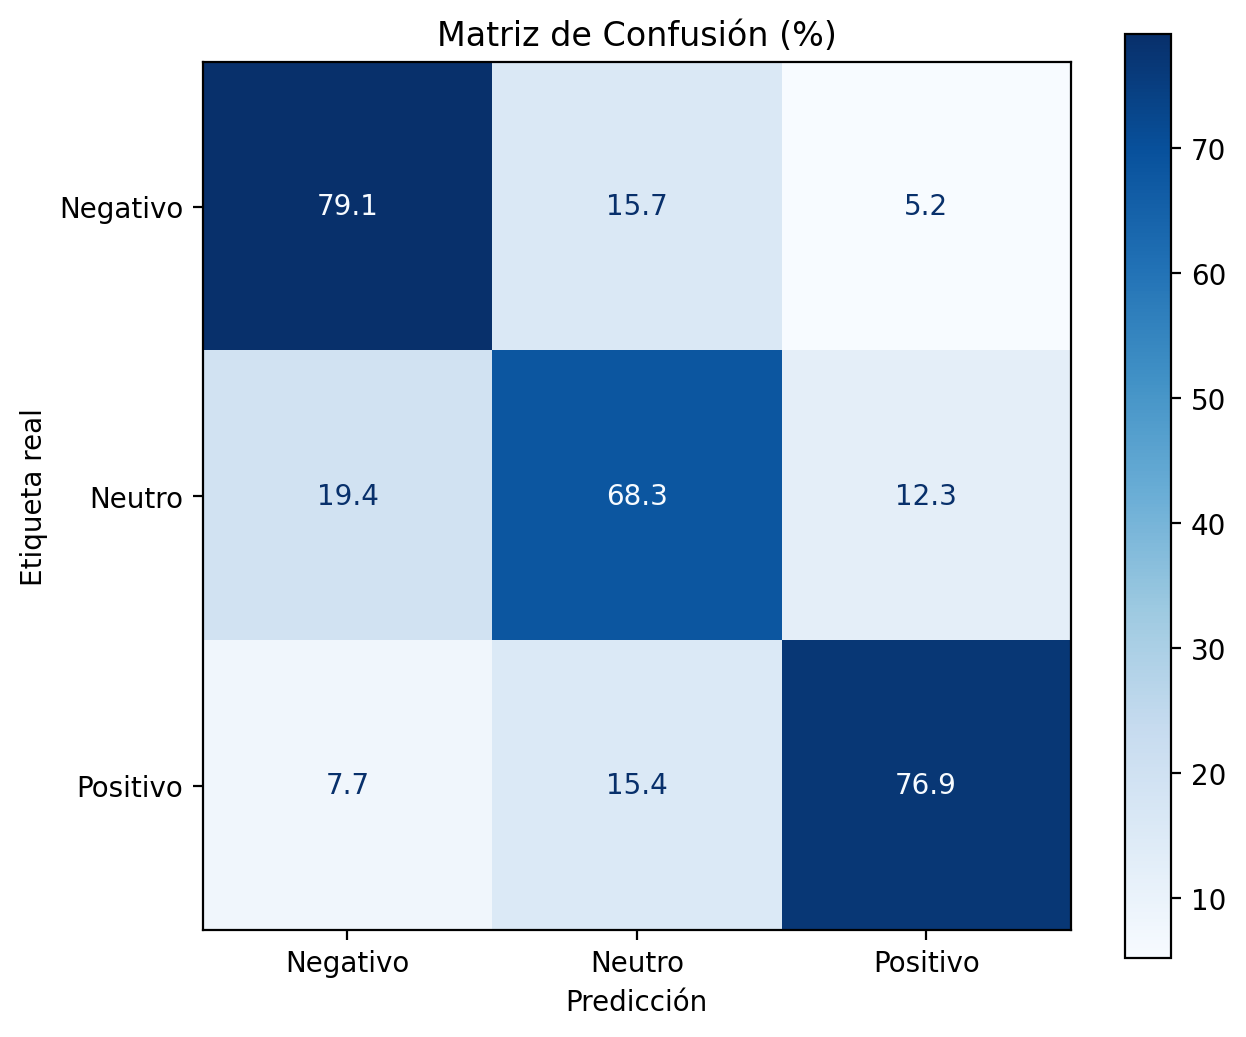

In [41]:
yPred = modelo.predict(xTest)
yPred_labels = np.argmax(yPred, axis=1)
yTest_labels = np.argmax(yTest, axis=1)

graficaMatrizPorcentaje(yTest_labels, yPred_labels)

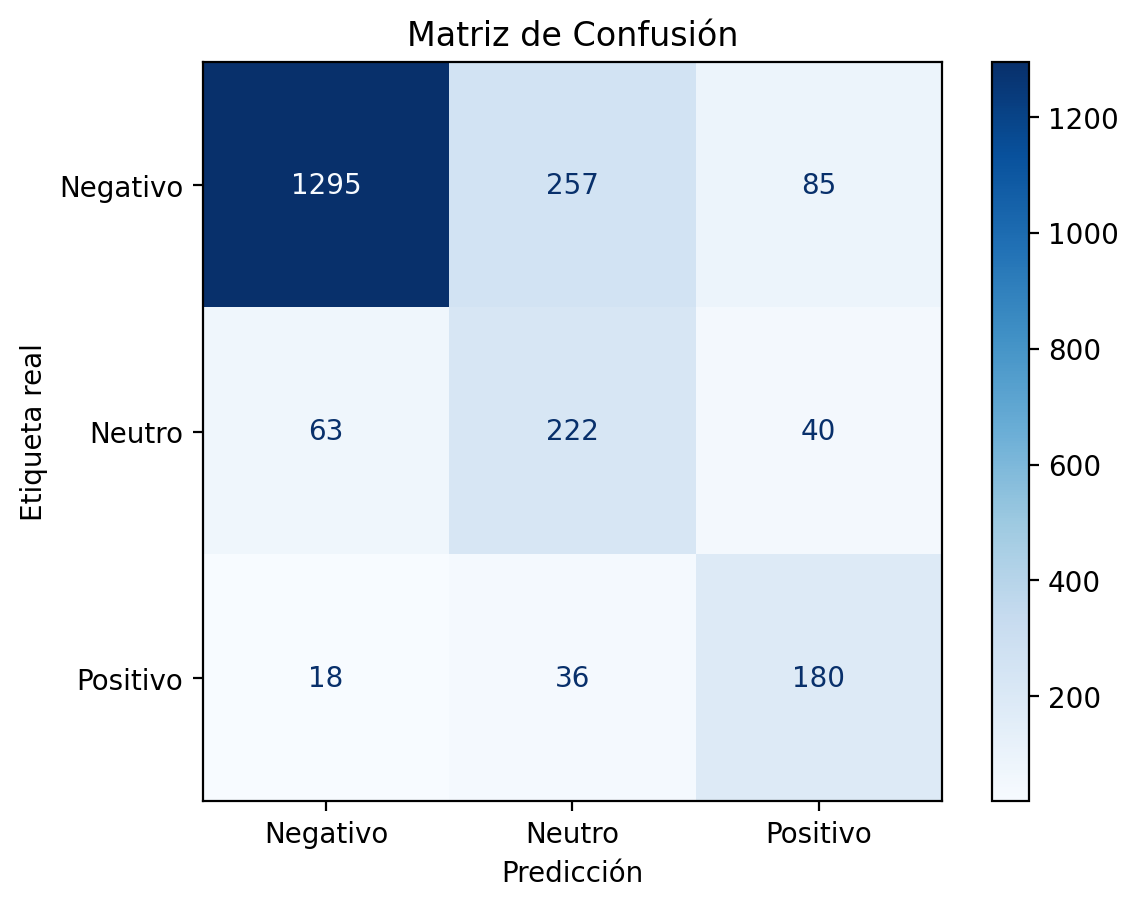

In [42]:
graficaMatriz(yTest_labels, yPred_labels)

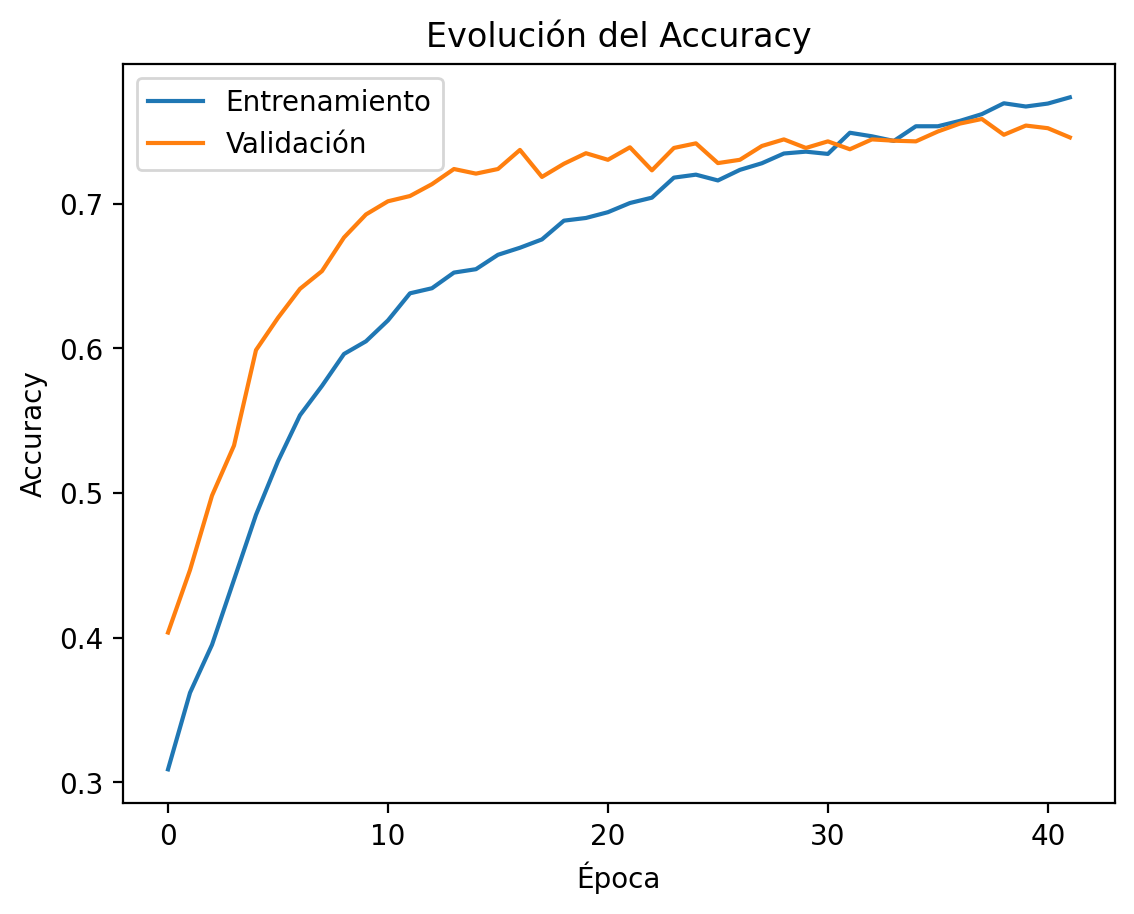

In [43]:
graficaEntrenamiento(resultado, "accuracy", "val_accuracy", "Evolución del Accuracy", "Accuracy")

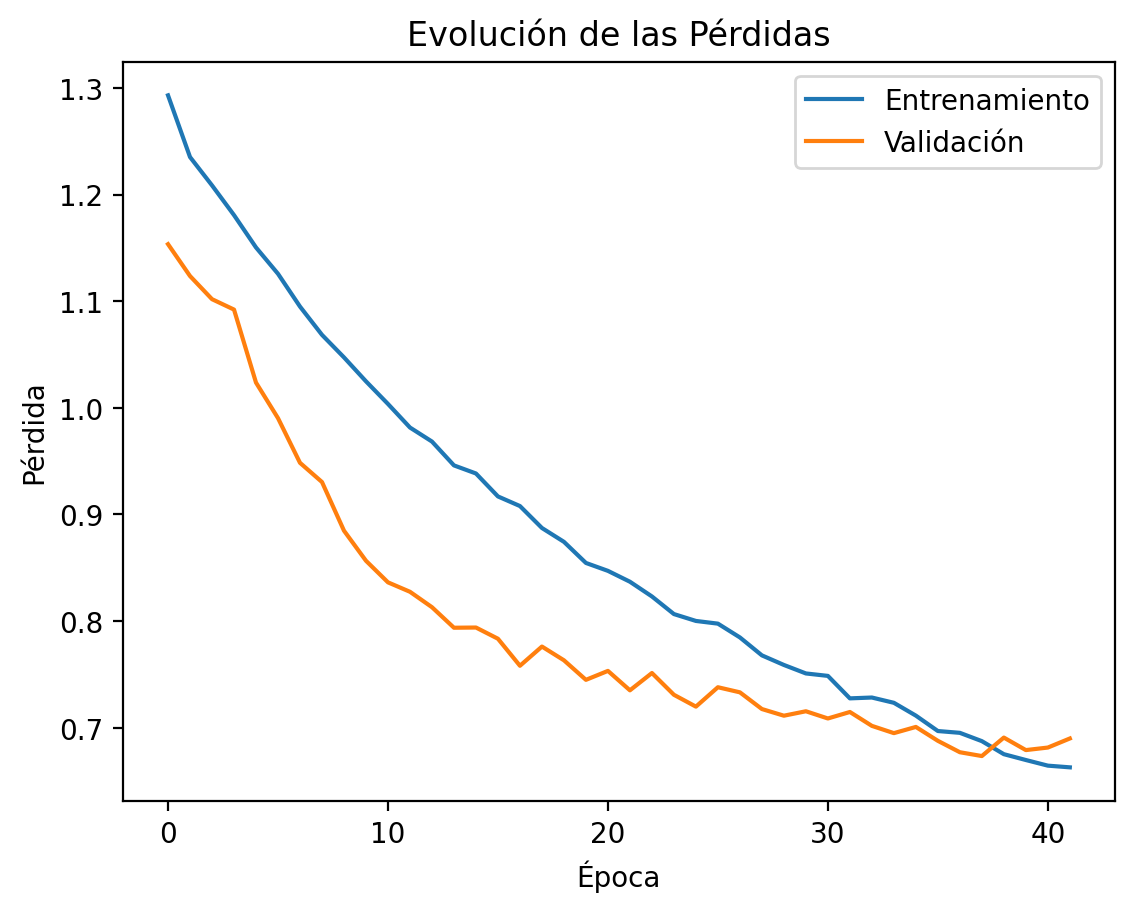

In [44]:
graficaEntrenamiento(resultado, "loss", "val_loss", "Evolución de las Pérdidas", "Pérdida")

## Pruebas Preliminares

**Parámetros base**

* 1 capa RNN de 64
* L2 = 0.001
* Dropout = 0.3
* Opt Adam LR = 0.00001
* EarlyStopping
* epocas = 200
* lote = 32
* sizeEmbedding = 164

Submuestreo con la misma cantidad de instancias en todas las clase

|![alt text](./Imágenes/3-1.png) | ![alt text](./Imágenes/3-2.png) | ![alt text](./Imágenes/3-3.png) |
|-|-|-

Submuestreo del 50% en la clase negativa

|![alt text](Imágenes/2-1.jpg) | ![alt text](Imágenes/2-2.jpg) | ![alt text](Imágenes/2-3.jpg) |
|-|-|-

Submuestreo del 80% en la clase negativa

|![alt text](Imágenes/1-3.png) | ![alt text](Imágenes/1-1.png) | ![alt text](Imágenes/1-2.png) |
|-|-|-

Sin submuestreo, solo con class weights

|![alt text](Imágenes/6-1.png) | ![alt text](Imágenes/6-2.png) | ![alt text](Imágenes/6-3.png) |
|-|-|-

L2 = 0.0001

|![alt text](Imágenes/7-1.png) | ![alt text](Imágenes/7-2.png) | ![alt text](Imágenes/7-3.png) |
|-|-|-

L2 = 0.01

|![alt text](Imágenes/8-1.png) | ![alt text](Imágenes/8-2.png) | ![alt text](Imágenes/8-3.png) |
|-|-|-

Dos capas de RNN 32 -> 16

|![alt text](Imágenes/9-1.png) | ![alt text](Imágenes/9-2.png) | ![alt text](Imágenes/9-3.png) |
|-|-|-

Dos capas de RNN 32 -> 16 con recurrent dropout 0.3

|![alt text](Imágenes/12-1.png) | ![alt text](Imágenes/12-2.png) | ![alt text](Imágenes/12-3.png) |
|-|-|-

Dos capas de RNN 32 -> 16 con normal dropout 0.3

|![alt text](Imágenes/13-1.png) | ![alt text](Imágenes/13-2.png) | ![alt text](Imágenes/13-3.png) |
|-|-|-

Tres capas de RNN 64 -> 32 -> 16

|![alt text](Imágenes/15-1.png) | ![alt text](Imágenes/15-2.png) | ![alt text](Imágenes/15-3.png) |
|-|-|-

Tres capas de RNN 64 -> 32 -> 16, todas bidireccionales

|![alt text](Imágenes/17-1.png) | ![alt text](Imágenes/17-2.png) | ![alt text](Imágenes/17-3.png) |
|-|-|-

Tres capas de RNN 64 -> 32 -> 16, primera bidireccional

|![alt text](Imágenes/18-1.png) | ![alt text](Imágenes/18-2.png) | ![alt text](Imágenes/18-3.png) |
|-|-|-